# Chapter 18 - Neural Networks

## Listing 18-1. Importing the data

In [1]:
import keras
import pandas as pd
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
del zip_file

df = df.drop('Date Time', axis=1)
cols = ['p',  'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'wv', 'mwv', 'wd']
df.columns = cols


## Listing 18-2. Creating the lagged dataset

In [2]:
y = df.loc[2*72:,'T']
lagged_x = []
for lag in range(72,2*72,12):
  lagged = df.shift(lag)
  lagged.columns = [x + '.lag' + str(lag) for x in lagged.columns]
  lagged_x.append(lagged)

df = pd.concat(lagged_x, axis=1)
df = df.iloc[2*72:,:] #drop missing values due to lags


## Listing 18-3. Fitting the MinMaxScaler

In [3]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)


## Listing 18-4. Fitting the full PCA

In [4]:
import mlflow
mlflow.autolog()

# Fit a PCA with maximum number of components
from sklearn.decomposition import PCA
mypca = PCA()
mypca.fit(df)


2025/05/27 18:45:53 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.9.2, but the installed version is 3.10.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2025/05/27 18:45:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/05/27 18:45:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/27 18:45:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/05/27 18:45:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b3dcf8f217114af491c7755f698609dd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/27 18:46:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically reco

PCA()

## Listing 18-5. Plotting the full PCA

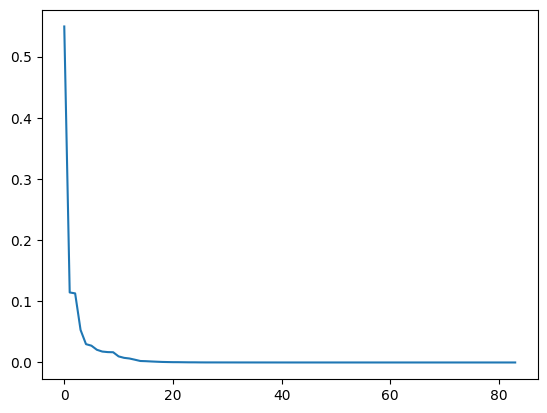

In [5]:
# Make a scree plot
import matplotlib.pyplot as plt
plt.plot(mypca.explained_variance_ratio_)
plt.show()


## Listing 18-6. Fitting the PCA with 10 components

In [6]:
mypca = PCA(10)
df = mypca.fit_transform(df)


2025/05/27 18:46:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '59a7d054f70c4dc7b314e108e54283c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/27 18:46:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/27 18:46:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


## Listing 18-7. Train test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)


## Listing 18-8. Specify the model and its architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
random.seed(42)

simple_model = Sequential([
  Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  Dense(64, activation='relu'),
  Dense(1),
])


/opt/anaconda3/envs/chapter18-20/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Listing 18-9. Obtain a summary of the model architecture

In [9]:
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,929 (19.25 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 0 (0.00 B)

## Listing 18-10. Compile the model

In [10]:
simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)


## Listing 18-11. Fit the model

In [11]:
smod_history = simple_model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=10,
          batch_size=32,
          shuffle = True
)


2025/05/27 18:46:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21bc0aad747b4388bdd1ba5002a6cbbe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/27 18:46:35 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
6965/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 2.7646 - mean_absolute_error: 2.7646

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 694us/step - loss: 2.7628 - mean_absolute_error: 2.7628 - val_loss: 2.5032 - val_mean_absolute_error: 2.5032
Epoch 2/10
6982/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 2.5023 - mean_absolute_error: 2.5023

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 682us/step - loss: 2.5022 - mean_absolute_error: 2.5022 - val_loss: 2.4579 - val_mean_absolute_error: 2.4579
Epoch 3/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 680us/step - loss: 2.4643 - mean_absolute_error: 2.4643 - val_loss: 2.4704 - val_mean_absolute_error: 2.4704
Epoch 4/10
6972/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 2.4474 - mean_absolute_error: 2.4474

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 676us/step - loss: 2.4474 - mean_absolute_error: 2.4474 - val_loss: 2.4477 - val_mean_absolute_error: 2.4477
Epoch 5/10
6964/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 2.4366 - mean_absolute_error: 2.4366

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 683us/step - loss: 2.4365 - mean_absolute_error: 2.4365 - val_loss: 2.4329 - val_mean_absolute_error: 2.4329
Epoch 6/10
7008/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 2.4136 - mean_absolute_error: 2.4136

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 671us/step - loss: 2.4136 - mean_absolute_error: 2.4136 - val_loss: 2.4167 - val_mean_absolute_error: 2.4167
Epoch 7/10
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 673us/step - loss: 2.4142 - mean_absolute_error: 2.4142 - val_loss: 2.4250 - val_mean_absolute_error: 2.4250
Epoch 8/10
6960/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 2.4144 - mean_absolute_error: 2.4144

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 676us/step - loss: 2.4144 - mean_absolute_error: 2.4144 - val_loss: 2.4073 - val_mean_absolute_error: 2.4073
Epoch 9/10
6987/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 2.4027 - mean_absolute_error: 2.4027

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 682us/step - loss: 2.4027 - mean_absolute_error: 2.4027 - val_loss: 2.4058 - val_mean_absolute_error: 2.4058
Epoch 10/10
7031/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 2.4028 - mean_absolute_error: 2.4028

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 5s 677us/step - loss: 2.4028 - mean_absolute_error: 2.4028 - val_loss: 2.3946 - val_mean_absolute_error: 2.3946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


## Listing 18-12. Plot the training history

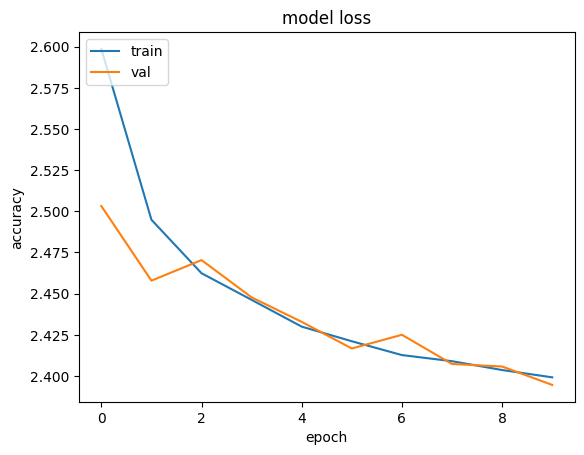

In [12]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Listing 18-13. A better architecture

/opt/anaconda3/envs/chapter18-20/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/27 18:47:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b9148c571c304d1f8d64f2441f12fbf0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/27 18:47:29 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0130 - mean_absolute_error: 3.0130  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 101s 14ms/step - loss: 3.0128 - mean_absolute_error: 3.0128 - val_loss: 2.5320 - val_mean_absolute_error: 2.5320
Epoch 2/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.5077 - mean_absolute_error: 2.5077 - val_loss: 2.5578 - val_mean_absolute_error: 2.5578
Epoch 3/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4245 - mean_absolute_error: 2.4245  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.4245 - mean_absolute_error: 2.4245 - val_loss: 2.3880 - val_mean_absolute_error: 2.3880
Epoch 4/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3723 - mean_absolute_error: 2.3723  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 2.3723 - mean_absolute_error: 2.3723 - val_loss: 2.3396 - val_mean_absolute_error: 2.3396
Epoch 5/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 2.3266 - mean_absolute_error: 2.3266 - val_loss: 2.3430 - val_mean_absolute_error: 2.3430
Epoch 6/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2885 - mean_absolute_error: 2.2885  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - loss: 2.2885 - mean_absolute_error: 2.2885 - val_loss: 2.2875 - val_mean_absolute_error: 2.2875
Epoch 7/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2525 - mean_absolute_error: 2.2525  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 2.2525 - mean_absolute_error: 2.2525 - val_loss: 2.2556 - val_mean_absolute_error: 2.2556
Epoch 8/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2239 - mean_absolute_error: 2.2239  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 2.2239 - mean_absolute_error: 2.2239 - val_loss: 2.2345 - val_mean_absolute_error: 2.2345
Epoch 9/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1889 - mean_absolute_error: 2.1889  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.1889 - mean_absolute_error: 2.1889 - val_loss: 2.2327 - val_mean_absolute_error: 2.2327
Epoch 10/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1523 - mean_absolute_error: 2.1523  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.1523 - mean_absolute_error: 2.1523 - val_loss: 2.2235 - val_mean_absolute_error: 2.2235
Epoch 11/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1247 - mean_absolute_error: 2.1247  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.1247 - mean_absolute_error: 2.1247 - val_loss: 2.1790 - val_mean_absolute_error: 2.1790
Epoch 12/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - loss: 2.1067 - mean_absolute_error: 2.1067 - val_loss: 2.1935 - val_mean_absolute_error: 2.1935
Epoch 13/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0696 - mean_absolute_error: 2.0696  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.0696 - mean_absolute_error: 2.0696 - val_loss: 2.1234 - val_mean_absolute_error: 2.1234
Epoch 14/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - loss: 2.0427 - mean_absolute_error: 2.0427 - val_loss: 2.1690 - val_mean_absolute_error: 2.1690
Epoch 15/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0290 - mean_absolute_error: 2.0290  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 2.0290 - mean_absolute_error: 2.0290 - val_loss: 2.1181 - val_mean_absolute_error: 2.1181
Epoch 16/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0014 - mean_absolute_error: 2.0014  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 2.0014 - mean_absolute_error: 2.0014 - val_loss: 2.0966 - val_mean_absolute_error: 2.0966
Epoch 17/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9858 - mean_absolute_error: 1.9858  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.9858 - mean_absolute_error: 1.9858 - val_loss: 2.0880 - val_mean_absolute_error: 2.0880
Epoch 18/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.9562 - mean_absolute_error: 1.9562 - val_loss: 2.0985 - val_mean_absolute_error: 2.0985
Epoch 19/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9404 - mean_absolute_error: 1.9404  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.9404 - mean_absolute_error: 1.9404 - val_loss: 2.0516 - val_mean_absolute_error: 2.0516
Epoch 20/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9154 - mean_absolute_error: 1.9154  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 1.9154 - mean_absolute_error: 1.9154 - val_loss: 2.0317 - val_mean_absolute_error: 2.0317
Epoch 21/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 1.8970 - mean_absolute_error: 1.8970 - val_loss: 2.0903 - val_mean_absolute_error: 2.0903
Epoch 22/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8757 - mean_absolute_error: 1.8757  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 95s 13ms/step - loss: 1.8757 - mean_absolute_error: 1.8757 - val_loss: 2.0269 - val_mean_absolute_error: 2.0269
Epoch 23/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8639 - mean_absolute_error: 1.8639  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.8639 - mean_absolute_error: 1.8639 - val_loss: 2.0167 - val_mean_absolute_error: 2.0167
Epoch 24/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8411 - mean_absolute_error: 1.8411  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.8411 - mean_absolute_error: 1.8411 - val_loss: 1.9897 - val_mean_absolute_error: 1.9897
Epoch 25/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8250 - mean_absolute_error: 1.8250  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.8250 - mean_absolute_error: 1.8250 - val_loss: 1.9830 - val_mean_absolute_error: 1.9830
Epoch 26/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8033 - mean_absolute_error: 1.8033  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 1.8033 - mean_absolute_error: 1.8033 - val_loss: 1.9730 - val_mean_absolute_error: 1.9730
Epoch 27/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.7929 - mean_absolute_error: 1.7929  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 800s 114ms/step - loss: 1.7929 - mean_absolute_error: 1.7929 - val_loss: 1.9660 - val_mean_absolute_error: 1.9660
Epoch 28/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7668 - mean_absolute_error: 1.7668  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 13ms/step - loss: 1.7668 - mean_absolute_error: 1.7668 - val_loss: 1.9591 - val_mean_absolute_error: 1.9591
Epoch 29/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7464 - mean_absolute_error: 1.7464  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 95s 13ms/step - loss: 1.7464 - mean_absolute_error: 1.7464 - val_loss: 1.9408 - val_mean_absolute_error: 1.9408
Epoch 30/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7377 - mean_absolute_error: 1.7377  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 1.7377 - mean_absolute_error: 1.7377 - val_loss: 1.9358 - val_mean_absolute_error: 1.9358
Epoch 31/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7232 - mean_absolute_error: 1.7232  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.7232 - mean_absolute_error: 1.7232 - val_loss: 1.9150 - val_mean_absolute_error: 1.9150
Epoch 32/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7049 - mean_absolute_error: 1.7049  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.7049 - mean_absolute_error: 1.7049 - val_loss: 1.9127 - val_mean_absolute_error: 1.9127
Epoch 33/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6939 - mean_absolute_error: 1.6939  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.6939 - mean_absolute_error: 1.6939 - val_loss: 1.9099 - val_mean_absolute_error: 1.9099
Epoch 34/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 1.6812 - mean_absolute_error: 1.6812 - val_loss: 1.9514 - val_mean_absolute_error: 1.9514
Epoch 35/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 1.6683 - mean_absolute_error: 1.6683 - val_loss: 1.9118 - val_mean_absolute_error: 1.9118
Epoch 36/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.6514 - mean_absolute_error: 1.6514 - val_loss: 1.9378 - val_mean_absolute_error: 1.9378
Epoch 37/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6431 - mean_absolute_error: 1.6431  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 247s 35ms/step - loss: 1.6431 - mean_absolute_error: 1.6431 - val_loss: 1.8804 - val_mean_absolute_error: 1.8804
Epoch 38/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6271 - mean_absolute_error: 1.6271  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 1.6271 - mean_absolute_error: 1.6271 - val_loss: 1.8734 - val_mean_absolute_error: 1.8734
Epoch 39/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6191 - mean_absolute_error: 1.6191  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 1.6192 - mean_absolute_error: 1.6192 - val_loss: 1.8605 - val_mean_absolute_error: 1.8605
Epoch 40/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6035 - mean_absolute_error: 1.6035  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 1.6035 - mean_absolute_error: 1.6035 - val_loss: 1.8593 - val_mean_absolute_error: 1.8593
Epoch 41/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 1.5853 - mean_absolute_error: 1.5853 - val_loss: 1.8770 - val_mean_absolute_error: 1.8770
Epoch 42/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5734 - mean_absolute_error: 1.5734  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.5734 - mean_absolute_error: 1.5734 - val_loss: 1.8361 - val_mean_absolute_error: 1.8361
Epoch 43/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 1.5644 - mean_absolute_error: 1.5644 - val_loss: 1.8422 - val_mean_absolute_error: 1.8422
Epoch 44/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.5488 - mean_absolute_error: 1.5488 - val_loss: 1.8427 - val_mean_absolute_error: 1.8427
Epoch 45/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5390 - mean_absolute_error: 1.5390  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 1.5390 - mean_absolute_error: 1.5390 - val_loss: 1.8096 - val_mean_absolute_error: 1.8096
Epoch 46/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 13ms/step - loss: 1.5249 - mean_absolute_error: 1.5249 - val_loss: 1.8158 - val_mean_absolute_error: 1.8158
Epoch 47/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5061 - mean_absolute_error: 1.5061  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.5062 - mean_absolute_error: 1.5062 - val_loss: 1.7916 - val_mean_absolute_error: 1.7916
Epoch 48/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5030 - mean_absolute_error: 1.5030  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 1.5030 - mean_absolute_error: 1.5030 - val_loss: 1.7908 - val_mean_absolute_error: 1.7908
Epoch 49/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.4965 - mean_absolute_error: 1.4965 - val_loss: 1.8098 - val_mean_absolute_error: 1.8098
Epoch 50/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.4858 - mean_absolute_error: 1.4858 - val_loss: 1.8291 - val_mean_absolute_error: 1.8291
Epoch 51/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4713 - mean_absolute_error: 1.4713  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 192s 27ms/step - loss: 1.4713 - mean_absolute_error: 1.4713 - val_loss: 1.7784 - val_mean_absolute_error: 1.7784
Epoch 52/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4594 - mean_absolute_error: 1.4594  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.4594 - mean_absolute_error: 1.4594 - val_loss: 1.7758 - val_mean_absolute_error: 1.7758
Epoch 53/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 1.4555 - mean_absolute_error: 1.4555 - val_loss: 1.7814 - val_mean_absolute_error: 1.7814
Epoch 54/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.4462 - mean_absolute_error: 1.4462 - val_loss: 1.8043 - val_mean_absolute_error: 1.8043
Epoch 55/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4304 - mean_absolute_error: 1.4304  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 1.4304 - mean_absolute_error: 1.4304 - val_loss: 1.7673 - val_mean_absolute_error: 1.7673
Epoch 56/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4152 - mean_absolute_error: 1.4152  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 1.4152 - mean_absolute_error: 1.4152 - val_loss: 1.7547 - val_mean_absolute_error: 1.7547
Epoch 57/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4102 - mean_absolute_error: 1.4102  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 101s 14ms/step - loss: 1.4103 - mean_absolute_error: 1.4103 - val_loss: 1.7426 - val_mean_absolute_error: 1.7426
Epoch 58/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 253s 36ms/step - loss: 1.3937 - mean_absolute_error: 1.3937 - val_loss: 1.7742 - val_mean_absolute_error: 1.7742
Epoch 59/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3998 - mean_absolute_error: 1.3998  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 206s 29ms/step - loss: 1.3998 - mean_absolute_error: 1.3998 - val_loss: 1.7377 - val_mean_absolute_error: 1.7377
Epoch 60/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3842 - mean_absolute_error: 1.3842  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.3842 - mean_absolute_error: 1.3842 - val_loss: 1.7369 - val_mean_absolute_error: 1.7369
Epoch 61/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 96s 14ms/step - loss: 1.3802 - mean_absolute_error: 1.3802 - val_loss: 1.7408 - val_mean_absolute_error: 1.7408
Epoch 62/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3739 - mean_absolute_error: 1.3739  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 1.3739 - mean_absolute_error: 1.3739 - val_loss: 1.7214 - val_mean_absolute_error: 1.7214
Epoch 63/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 95s 13ms/step - loss: 1.3612 - mean_absolute_error: 1.3612 - val_loss: 1.7274 - val_mean_absolute_error: 1.7274
Epoch 64/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3555 - mean_absolute_error: 1.3555  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.3555 - mean_absolute_error: 1.3555 - val_loss: 1.7105 - val_mean_absolute_error: 1.7105
Epoch 65/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - loss: 1.3375 - mean_absolute_error: 1.3375 - val_loss: 1.7219 - val_mean_absolute_error: 1.7219
Epoch 66/100
7038/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3424 - mean_absolute_error: 1.3424  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 13ms/step - loss: 1.3425 - mean_absolute_error: 1.3425 - val_loss: 1.7052 - val_mean_absolute_error: 1.7052
Epoch 67/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3247 - mean_absolute_error: 1.3247  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 106s 15ms/step - loss: 1.3247 - mean_absolute_error: 1.3247 - val_loss: 1.7035 - val_mean_absolute_error: 1.7035
Epoch 68/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.3237 - mean_absolute_error: 1.3237 - val_loss: 1.7122 - val_mean_absolute_error: 1.7122
Epoch 69/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 1.3092 - mean_absolute_error: 1.3092 - val_loss: 1.7412 - val_mean_absolute_error: 1.7412
Epoch 70/100
7039/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3007 - mean_absolute_error: 1.3007  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - loss: 1.3007 - mean_absolute_error: 1.3007 - val_loss: 1.6947 - val_mean_absolute_error: 1.6947
Epoch 71/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3297 - mean_absolute_error: 1.3297  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 96s 14ms/step - loss: 1.3297 - mean_absolute_error: 1.3297 - val_loss: 1.6775 - val_mean_absolute_error: 1.6775
Epoch 72/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.2943 - mean_absolute_error: 1.2943 - val_loss: 1.6986 - val_mean_absolute_error: 1.6986
Epoch 73/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 89s 13ms/step - loss: 1.2841 - mean_absolute_error: 1.2841 - val_loss: 1.6821 - val_mean_absolute_error: 1.6821
Epoch 74/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - loss: 1.2837 - mean_absolute_error: 1.2837 - val_loss: 1.6923 - val_mean_absolute_error: 1.6923
Epoch 75/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.2689 - mean_absolute_error: 1.2689 - val_loss: 1.6809 - val_mean_absolute_error: 1.6809
Epoch 76/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 97s 14ms/step - loss: 1.2679 - mean_absolute_error: 1.2679 - val_loss: 1.6788 - val_mean_absolute_error: 1.6788
Epoch 77/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.2664 - me

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 95s 14ms/step - loss: 1.2457 - mean_absolute_error: 1.2457 - val_loss: 1.6534 - val_mean_absolute_error: 1.6534
Epoch 80/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 1.2487 - mean_absolute_error: 1.2487 - val_loss: 1.7079 - val_mean_absolute_error: 1.7079
Epoch 81/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 88s 13ms/step - loss: 1.2539 - mean_absolute_error: 1.2539 - val_loss: 1.6678 - val_mean_absolute_error: 1.6678
Epoch 82/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 97s 14ms/step - loss: 1.2418 - mean_absolute_error: 1.2418 - val_loss: 1.6955 - val_mean_absolute_error: 1.6955
Epoch 83/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 222s 32ms/step - loss: 1.2302 - mean_absolute_error: 1.2302 - val_loss: 1.6818 - val_mean_absolute_error: 1.6818
Epoch 84/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 1.2256 - mean_absolute_error: 1.2256 - val_loss: 1.6742 - val_mean_absolute_error: 1.6742
Epoch 85/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.2142 - m

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.2252 - mean_absolute_error: 1.2252 - val_loss: 1.6423 - val_mean_absolute_error: 1.6423
Epoch 89/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2182 - mean_absolute_error: 1.2182  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 1.2182 - mean_absolute_error: 1.2182 - val_loss: 1.6377 - val_mean_absolute_error: 1.6377
Epoch 90/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.1932 - mean_absolute_error: 1.1932 - val_loss: 1.6382 - val_mean_absolute_error: 1.6382
Epoch 91/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.2000 - mean_absolute_error: 1.2000 - val_loss: 1.6440 - val_mean_absolute_error: 1.6440
Epoch 92/100
7041/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1858 - mean_absolute_error: 1.1858  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.1858 - mean_absolute_error: 1.1858 - val_loss: 1.6351 - val_mean_absolute_error: 1.6351
Epoch 93/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 1.2102 - mean_absolute_error: 1.2102 - val_loss: 1.6722 - val_mean_absolute_error: 1.6722
Epoch 94/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - loss: 1.3948 - mean_absolute_error: 1.3948 - val_loss: 1.6707 - val_mean_absolute_error: 1.6707
Epoch 95/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - loss: 1.2506 - mean_absolute_error: 1.2506 - val_loss: 1.6427 - val_mean_absolute_error: 1.6427
Epoch 96/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.1994 - mean_absolute_error: 1.1994 - val_loss: 1.6537 - val_mean_absolute_error: 1.6537
Epoch 97/100
7040/7042 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1821 - mean_absolute_error: 1.1821  

7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.1821 - mean_absolute_error: 1.1821 - val_loss: 1.6248 - val_mean_absolute_error: 1.6248
Epoch 98/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 1.1609 - mean_absolute_error: 1.1609 - val_loss: 1.6397 - val_mean_absolute_error: 1.6397
Epoch 99/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 1.1569 - mean_absolute_error: 1.1569 - val_loss: 1.6315 - val_mean_absolute_error: 1.6315
Epoch 100/100
7042/7042 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.1655 - mean_absolute_error: 1.1655 - val_loss: 1.6398 - val_mean_absolute_error: 1.6398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


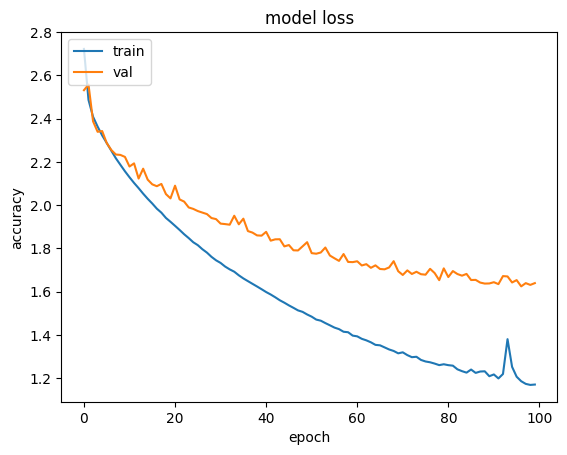

4336/4336 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
0.9156202134849101


In [13]:
from sklearn.metrics import r2_score

random.seed(42)
model = Sequential([
  Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(256, activation='relu'),
  Dense(1), ])
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

history = model.fit(X_train, y_train,
          #validation_data=(X_test, y_test),
          validation_split=0.2,
          epochs=100,
          batch_size=32,
          shuffle = True
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds = model.predict(X_test)
print(r2_score(preds, y_test))

